Running simulation at T* = 0.3 ...


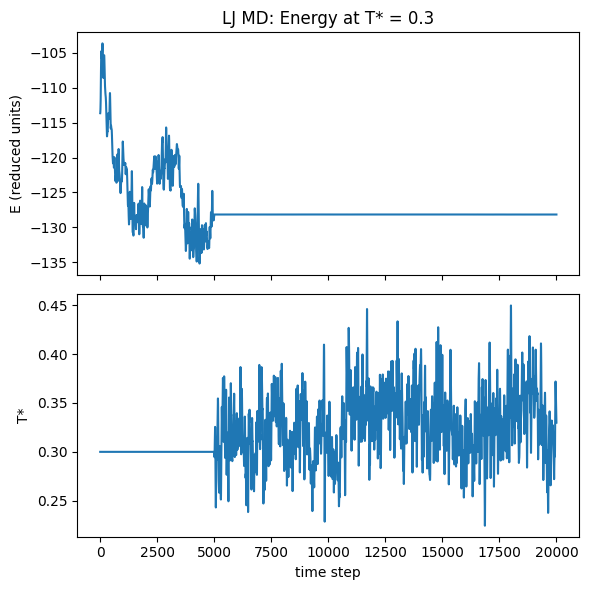

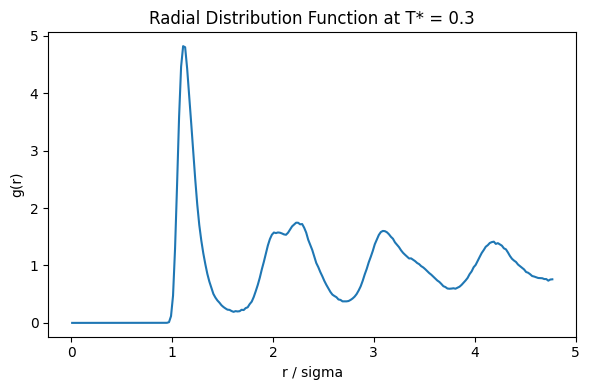

Running simulation at T* = 0.8 ...


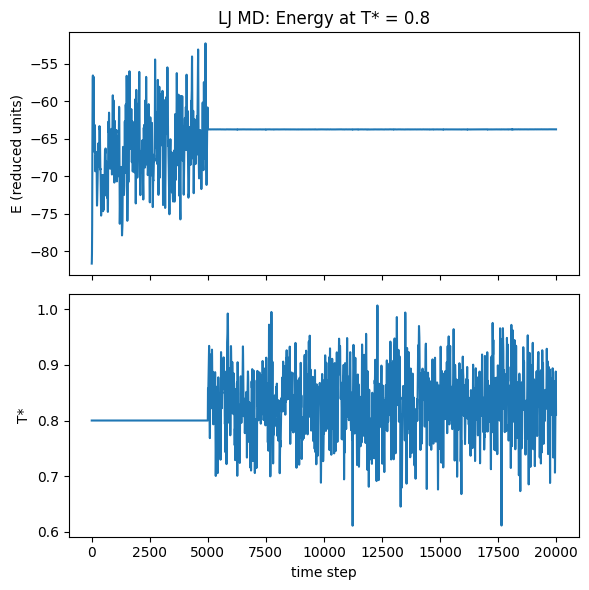

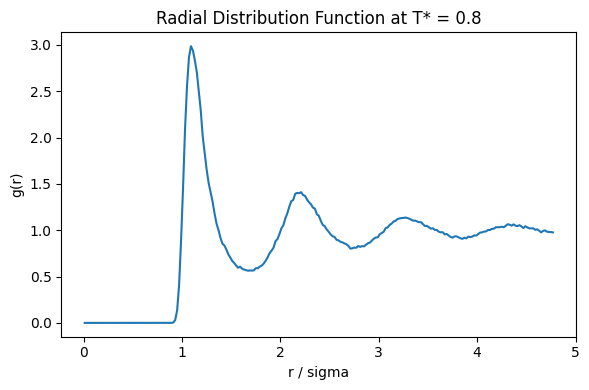

Running simulation at T* = 1.5 ...


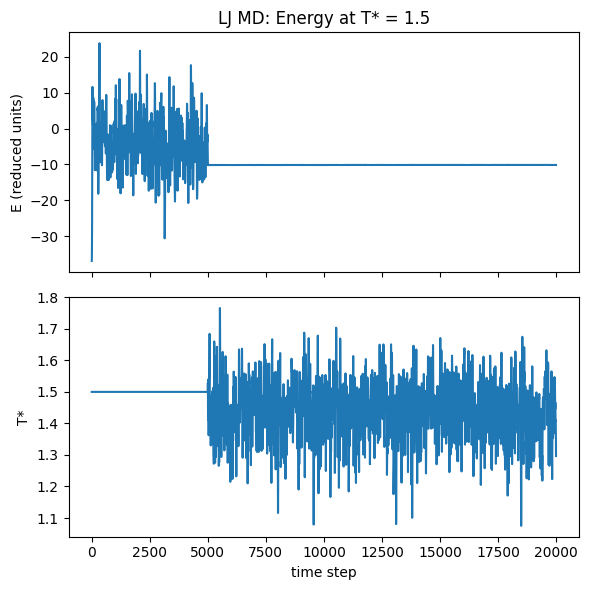

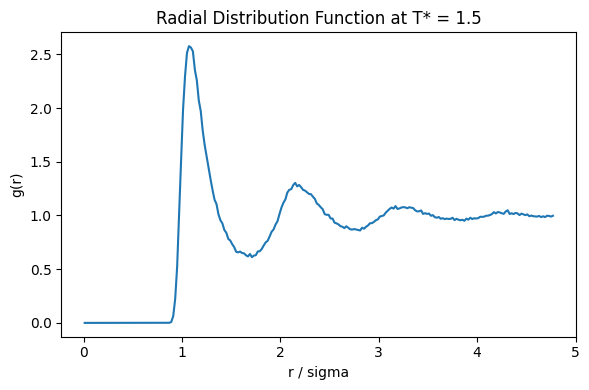

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ===== 전역 파라미터 =====
dim = 2                # 2D
N = 64                 # 입자 수
rho = 0.7              # number density = N / L^2
L = np.sqrt(N / rho)   # 박스 길이
dt = 0.003             # time step
steps = 20000          # 총 스텝 수
equil_steps = 5000     # 온도 맞추는 평형화 구간
sample_interval = 10   # 샘플 간격(애니메이션 + RDF용)

rc = 2.5               # cutoff (sigma 단위)
rc2 = rc * rc

# LJ reduced unit
epsilon = 1.0
sigma = 1.0
mass = 1.0
kB = 1.0


# ===== 유틸 함수들 =====
def init_positions(N, L):
    """정사각 격자로 초기 위치 배치"""
    n_side = int(np.ceil(np.sqrt(N)))
    spacing = L / n_side
    xs = (np.arange(n_side) + 0.5) * spacing
    ys = (np.arange(n_side) + 0.5) * spacing
    X, Y = np.meshgrid(xs, ys)
    pos = np.vstack([X.ravel(), Y.ravel()]).T[:N].copy()
    return pos


def init_velocities(N, T_target, dim=2):
    """가우시안에서 뽑고, 총운동량 0 & 목표 온도로 rescale"""
    v = np.random.normal(0.0, 1.0, size=(N, dim))
    v -= v.mean(axis=0, keepdims=True)  # P_tot = 0
    K = 0.5 * mass * np.sum(v**2)
    T_current = 2 * K / (dim * N * kB)
    scale = np.sqrt(T_target / T_current)
    v *= scale
    return v


def minimum_image(dr, L):
    #minimum image convention (Periodic boundary conditions)
    dr -= L * np.rint(dr / L)
    return dr


def compute_forces(positions, L):
    #모든 쌍들에 대해서 LJ 힘 + 포텐셜 (truncate & shift)
    N = positions.shape[0]
    forces = np.zeros_like(positions)
    potential = 0.0

    # cutoff에서의 퍼텐셜 (shift위해서...)
    inv_rc2 = 1.0 / rc2
    inv_rc6 = inv_rc2**3
    v_shift = 4 * epsilon * (inv_rc6**2 - inv_rc6)

    for i in range(N - 1):
        for j in range(i + 1, N):
            dr = positions[i] - positions[j]
            dr = minimum_image(dr, L)
            r2 = np.dot(dr, dr)
            if r2 < rc2:
                inv_r2 = 1.0 / r2
                inv_r6 = inv_r2**3
                inv_r12 = inv_r6**2

                # LJ 포텐셜 (shift 포함)
                v_ij = 4 * epsilon * (inv_r12 - inv_r6) - v_shift
                potential += v_ij

                # force 계산
                force_scalar = 24 * epsilon * (2 * inv_r12 - inv_r6) * inv_r2
                fij = force_scalar * dr
                forces[i] += fij
                forces[j] -= fij

    return forces, potential


def velocity_verlet(positions, velocities, forces, L, dt):
    #velocity Verlet 한 스텝
    #위치 업데이트
    positions = positions + velocities * dt + 0.5 * forces / mass * dt * dt
    positions %= L  # PBC

    # 새로운 힘 계산
    new_forces, potential = compute_forces(positions, L)

    #속도 업데이트
    velocities = velocities + 0.5 * (forces + new_forces) / mass * dt

    return positions, velocities, new_forces, potential


def compute_temperature(velocities):
    K = 0.5 * mass * np.sum(velocities**2)
    T = 2 * K / (dim * velocities.shape[0] * kB)
    return T, K


def rescale_velocities(velocities, T_target):
    """단순 velocity rescaling thermostat"""
    T_current, _ = compute_temperature(velocities)
    scale = np.sqrt(T_target / T_current)
    velocities *= scale
    return velocities


# ===== RDF (에러 수정 버전) =====
def compute_rdf(samples, L, dr=0.02, r_max=None):
    """
    2D RDF g(r) 계산.
    samples: (n_samples, N, 2) 위치 배열
    """
    if r_max is None:
        r_max = L / 2.0

    n_bins = int(r_max / dr)
    hist = np.zeros(n_bins)

    N = samples.shape[1]
    rho = N / (L * L)
    n_samples = samples.shape[0]

    for pos in samples:
        for i in range(N - 1):
            dr_vec = pos[i+1:] - pos[i]         # (N-i-1, 2)
            dr_vec = minimum_image(dr_vec, L)
            r = np.sqrt(np.sum(dr_vec**2, axis=1))

            # r < r_max 만
            mask = r < r_max
            r = r[mask]
            if r.size == 0:
                continue

            # bin index 계산 (부동소수점 오차로 인한 overflow 방지용 클리핑 포함)
            bin_indices = np.floor(r / dr).astype(int)
            bin_indices = bin_indices[bin_indices < n_bins]
            if bin_indices.size == 0:
                continue

            # (i,j)와 (j,i) 둘 다 카운트 → *2
            np.add.at(hist, bin_indices, 2)

    # 정규화
    r_values = (np.arange(n_bins) + 0.5) * dr
    shell_areas = 2 * np.pi * r_values * dr           # 2D 원환(shell) 면적
    norm = rho * N * n_samples * shell_areas
    g_r = hist / norm

    return r_values, g_r


# ===== 메인 시뮬레이션 =====
def run_simulation(T_target=0.8, steps=steps, equil_steps=equil_steps):
    #한 온도에서 고정하여 MD 실행 후 T, E, 샘플 위치 반환
    positions = init_positions(N, L)
    velocities = init_velocities(N, T_target, dim)
    forces, pot = compute_forces(positions, L)

    temps = []
    energies = []
    samples = []

    for step in range(steps):
        positions, velocities, forces, pot = velocity_verlet(
            positions, velocities, forces, L, dt
        )

        T, K = compute_temperature(velocities)
        E = K + pot

        # 초기 평형 구간에서만 thermostat 작동
        if step < equil_steps:
            velocities = rescale_velocities(velocities, T_target)
            T, K = compute_temperature(velocities)
            E = K + pot

        temps.append(T)
        energies.append(E)

        if step % sample_interval == 0:
            samples.append(positions.copy())

    samples = np.array(samples)
    return np.array(temps), np.array(energies), samples, L


def make_animation(samples, L, interval=50):
    """샘플들을 이용한 2D 입자 애니메이션"""
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    scat = ax.scatter([], [])

    def init():
        scat.set_offsets(np.zeros((0, 2)))
        return scat,

    def update(frame):
        pos = samples[frame]
        scat.set_offsets(pos)
        ax.set_title(f"MD LJ, frame {frame}")
        return scat,

    anim = FuncAnimation(fig, update, frames=len(samples),
                         init_func=init, blit=True, interval=interval)
    return fig, anim


# ===== 실행부 =====
if __name__ == "__main__":
    T_list = [0.3, 0.8, 1.5]

    for T_target in T_list:
        print(f"Running simulation at T* = {T_target} ...")
        temps, energies, samples, Lbox = run_simulation(T_target=T_target)

        # --- 에너지 / 온도 플롯 ---
        fig1, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
        axes[0].plot(energies)
        axes[0].set_ylabel("E (reduced units)")
        axes[0].set_title(f"LJ MD: Energy at T* = {T_target}")

        axes[1].plot(temps)
        axes[1].set_ylabel("T*")
        axes[1].set_xlabel("time step")

        plt.tight_layout()
        plt.show()

        # --- RDF 계산 및 플롯 ---
        r_vals, g_r = compute_rdf(samples, Lbox, dr=0.02)
        plt.figure(figsize=(6, 4))
        plt.plot(r_vals, g_r)
        plt.xlabel("r / sigma")
        plt.ylabel("g(r)")
        plt.title(f"Radial Distribution Function at T* = {T_target}")
        plt.tight_layout()
        plt.show()

        